* Actual coding begins at `17:39`
* Updated version of this lesson available at :: https://www.kaggle.com/code/ailobe/fastai-ml1-lesson2-rf-interpretation/notebook
* The command `git restore .` will remove any changes and allow fresh pull from repo

# Random Forest Interpretation - Chapter 4

# 0. Pre-Discussion

* `set_rf_samples` means how many of the samples are made from the tree
* Before we start making trees we have two choiced
    * Sample w replacement from the entire dataset
    * Subsampling from the dataset 
* In the latter, the trees are made from only a small variation of the set 
* This is a trick oftenly done when dataset is very large
* The subsamples are also sometimes called `bootstrap samples`

---

* On `growth scale` of rf, consider the size to be $\log_2 (set\ rf\ samples)$
* The `no. of leaf nodes` is equal to the set_rf_samples
* Hence there is a `linear relationship` between set_rf_samples and number of leaf nodes
* So, in a sense, number of rf samples also decides the number of decisions made by the rf
* Therefore, the RF is going to be `less rich` in what it can predict as it will make `less binary choices` 
* How this relates to overfitting ? --> basically having low rfsamples will mean `less chances` of `overfitting`
* But it also means each of the individual tree in the forest will be `less accurate`

---

* Now looking in-depth what the idealogy about models with `bagging` is 
* You are trying to do two things:
    * A) Each individual estimator is as accurate as possible $\uparrow$ on the training set
    * B) The correlation between the estimators is low as possible $\downarrow$
    * So when you `average them out` together you end up with `better generalization`
* Hence, by setting set_rf_samples with a low number, you are decreasing the `A` factor and increasing the `B` factor

---

* Now what happens when you set `oob_score` to True
* In this case, remind yourself that there is these `residual` rows that did'net get included in the training set after the `subsampling stage`
* You can essentially construct a `quasi` validation set from this
* Obviously if you do not prefer this, it is possible to use `reset_rf_samples()` which simply sets rfsamples to 0 and uses the entire dataset, you WONT be able to use `oob_score` anymore now!

---

* Nextup is `min_samples_leaf` , setting this from (for eg) from 1 to 2, means that the depth of the decision tree will be `subtracted by 1`
* Because everytime we `double` the min_samples_leaf, we are removing `one layer` from the forest
* And the number of leaves will be `halved` if min_samples_leaf is `doubled`
* In this case, increasing min_samples_leaf will decrease `(A)` and increase `(B)` which `might` help us from `overfitting`
* Ideal choices for min_samples_leaf can be: *1, 3, 5, 10, 25, 100*

---

* Finally, the `max_features` determines how much portion of the features are selected `per-split`
* So if max_feautures = 0.5, then at each split, we take 0.5 of the features
* This will `reduce` the `coorelation` between the individual trees and *MAY* help with overfitting 
* The trade-off is that each of the tree will be `less accurate`
* Options you can have for `max_features` is :
    > sqrt for allow the sqrt of features

    > log2 to allow log2 of the number of features set
    
    > None means have all of them available at each split

# 1. Libraries and Modules Import

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
currDir = os.getcwd()
os.chdir("../fastai/")
from structured import *       
from imports import *
os.chdir(currDir)
# ____________________________________________________________ #
from pandas_summary import DataFrameSummary
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# ____________________________________________________________ #
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH2DATA = "../datasets/kaggle/bluebook_bulldozers/"
# !dir "../datasets/kaggle/corporcion_favorita_grocery_sales/"

# below is just the param to control different features in a graph plot
set_plot_sizes(12, 14, 16)


# 2. Load dataset and Pre-Process

In [4]:
df_raw = pd.read_csv(f'{PATH2DATA}Train.csv',
                     low_memory=False, parse_dates=["saledate"])

# convert the columns to log
df_raw.SalePrice = np.log(df_raw.SalePrice)

# extract timeOfDay, timeOfMonth etc from time and date
add_datepart(df_raw, 'saledate')

# categorical to numeric - partly
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(
    ["High", "Medium", "Low"], ordered=True, inplace=True)

# use proc_df to quantify string columns
df_train, y_train, _ = proc_df(df_raw, 'SalePrice')


In [5]:
def split_vals(a, n):
    """
    a: number of samples (i.e. the entire dataset)
    n: number of training set to split
    """
    # a[:n] will retrieve the first (N - n_valid) rows for TRAINING set
    # a[n:] will retirve the last (N - n_valid) rows got VALIDATION set
    return a[:n].copy(), a[n:].copy()

n_valid = 12000

# the number of training sets will be len(df) - n_valid
n_trn = len(df_train) - n_valid

# now split the entire dataset into training and validation
raw_train, raw_valid = split_vals(df_raw, n_trn)

# before were raw, now get the real ones based on pre-processed version
X_train, X_valid = split_vals(df_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

In [6]:
print("X_train shape: {}, y_train shape : {},  x_valid shape : {}".format(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape))

X_train shape: (389125, 66), y_train shape : (389125,),  x_valid shape : (12000, 66)


# 3. Model Setup and Initial Run

## 3.1. Some pre-defined functions for output and visualization

In [7]:
# function that will take the RMSE
def rmse(pred, known):
    return np.sqrt(((pred-known)**2).mean())

# function to round ans. to 5dp like Kaggle leaderboard answers


def rounded(value):
    return np.round(value, 5)

# function to return the rmse scores and R^2 values for train and validation set


def print_scores(model):
    RMSE_train = rmse(model.predict(X_train), y_train)
    RMSE_valid = rmse(model.predict(X_valid), y_valid)
    R2_train = model.score(X_train, y_train)
    R2_valid = model.score(X_valid, y_valid)

    # list the scores and check if oob_score is present
    scores = [rounded(RMSE_train), rounded(RMSE_valid),
              rounded(R2_train), rounded(R2_valid)]
    if hasattr(model, 'oob_score_'):
        scores.append(model.oob_score_)
    print(scores)

## 3.2. Subsampling

* Interpretation of the model has less to do with getting the `best accuracy` and more into the `insights` regarding the data
* In other words, how are the features within the data `correlated`
* For this to be tested, the model must first be `reliable`
* But also, when subsampling we need to make sure the subsample is `large enough` so that the model is reliable
* For this example we use about 50000 samples
* Recall that `oob_score=True` is only used when dataset is big enough to allow four split

In [8]:
# set_rf_samples(5000)   # the old set_rf_samples is causing error

# first run of the model
model1st = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                                 n_jobs=-1, oob_score=True, random_state=17190)

In [9]:
# fit the model and measure time taken
%time model1st.fit(X_train, y_train)

Wall time: 41.3 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1, oob_score=True, random_state=17190)

# 4. RF Uncertainty Analysis

### 4.1. Gathering Predictions and Variance based on predictions (judge on valid_set)

* Basically here we want to investigate the `relative confidence` of predictions
* We explore this by computing the standard deviation
* Hence, a *low* standard deviation indicates points that are closer to mean, *high* standard dev means they are spread over a *wider range of values*
* Some rows might lead the model to output higher variance and make our model give unreliable predictions

In [10]:
# loop through the estimators and get predictions on validation set
# then concatentate this predictions on seperate index
preds = np.stack([tree.predict(X_valid) for tree in model1st.estimators_])

# output the shape of the prediction, should be same size as 2nd axis of valid set shape
print("Predictions shape : {}".format(preds.shape))


Predictions shape : (40, 12000)


* The first axis represents the number of trees, this should be obvs. the same as `num_estimators` set when initialising the rf algorithm, in this case 40
* The second axis represents the number of predictions, in this case 12000, obv. should be same as the total amount of validation set
* Now, we will store a seperate copy of validation set with the added information of uncertainty
* We use `df_raw` instead of `x_train` since proc_df takes turns all columns to numbers removing the `conceptual meaning` of the uncertainty

In [11]:
# split df_raw
_, raw_valid = split_vals(df_raw, n_trn)

# make a copy of this valid set
validation = raw_valid.copy()

# append the two new columns below
validation['pred_stdeviation'] = np.std(preds, axis=0)
validation['pred_mean'] = np.mean(preds, axis=0)

* Now we move to analyzing and focusing information from mean and std
* However, we need to decide which columns to emphasize our analysis on
* Normally, for large equipments it would make sense to focus on `year of manufacture` and `size of machine` (in the table it is `productSize`)
* We can have a look and see that more products have been made in recent years, however, the trend is unclear as there are fluctuations in time intervals and some outliers e.g. 2010, 2011 and 2013
* Perhaps, we can understand this trend better by observing its correlation (if possible) with product sizes
* Hence, we look at plots for `counts` of unique values of *year made* and *product size* in the following sections

### 4.2. Analyzing UQ on Year Made First

<AxesSubplot:>

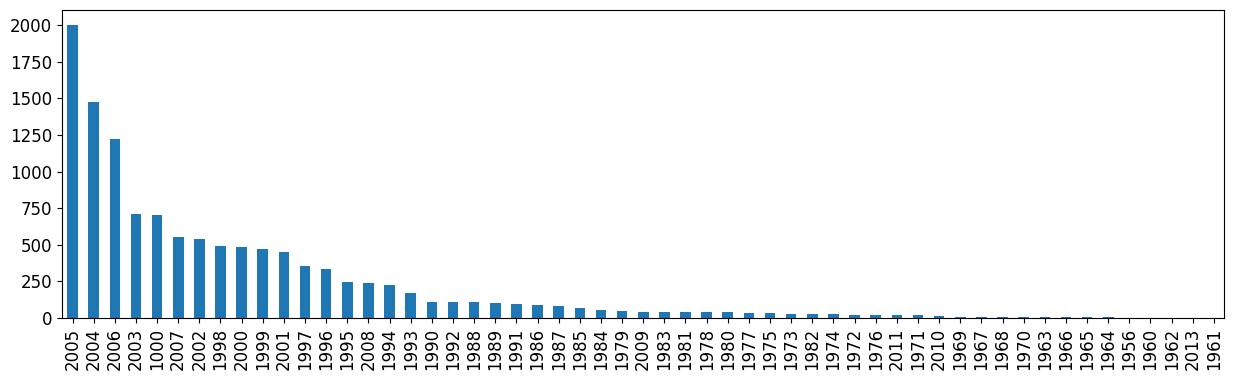

In [12]:
validation.YearMade.value_counts(dropna=False).plot.bar(figsize=(15, 4))

* We then plot those examples which have the highest standard deviation
* We pick the first 10 most highest stdeviation

In [25]:
validation[columns]

,YearMade,SalePrice,pred_mean,pred_stdeviation
389125,1999,9.104980,9.209288,0.205733
389126,1996,9.047821,9.169981,0.180591
389127,1993,9.104980,9.158360,0.147967
389128,2000,9.259131,9.271536,0.224899
389129,1999,9.104980,9.100349,0.142748
...,...,...,...,...
401120,2005,9.259131,9.455089,0.247058
401121,2005,9.305651,9.457819,0.246364
401122,2005,9.350102,9.455089,0.247058
401123,2005,9.104980,9.340345,0.178386


In [29]:
# get the list of selected columns
columns = ['YearMade', 'SalePrice', 'pred_mean', 'pred_stdeviation']

# isolate only the aforementioned columns from the validation set and then sort them by year made
# then take the average of these values and store them as year
year = validation[columns].groupby(columns[0]).mean()

# output the shape of this new frame
print("New frame based on year made, sale price and 1stand2nd moments : {}".format(year.shape))

# get the first 10 rows in descending order
year.sort_values(by=['pred_stdeviation'], ascending=False).head(10)

New frame based on year made, sale price and 1stand2nd moments : (55, 3)


,SalePrice,pred_mean,pred_stdeviation
YearMade,,,
1962,9.104980,9.506822,0.400461
1961,9.132379,9.413597,0.395902
1000,9.769063,9.708842,0.340629
1956,8.987197,9.290624,0.339080
1968,9.573605,9.587489,0.323670
1970,9.496778,9.455701,0.311912
1975,9.980834,9.939274,0.307105
1976,10.055493,9.982913,0.298635
1978,9.962585,9.989627,0.298082


### 4.3. Focusing on Analysing UQ on Product Size

* Remember `dropna` means dont count values that are NaNs when set to False
* Below, we are mainly trying to see of all of the product sizes, how much is the count for each val
* And then draw this out as a `bar chart` as shown below

<AxesSubplot:>

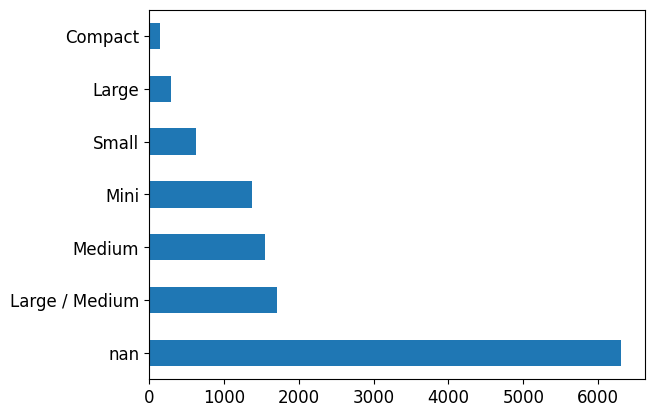

In [22]:
validation.ProductSize.value_counts(dropna=False).plot.barh()

<AxesSubplot:ylabel='ProductSize'>

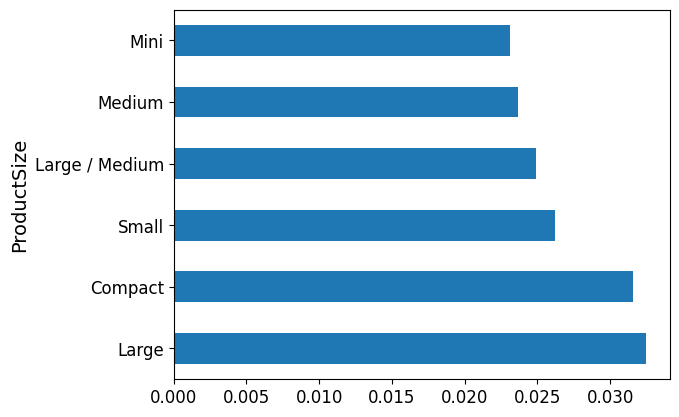

In [27]:
# isolate columns based on product size
columns = ['ProductSize', 'SalePrice', 'pred_mean', 'pred_stdeviation']

# group validation set based on product size
size = validation[columns].groupby(columns[0]).mean()

# draw out the ratio between mean and variance
(size.pred_stdeviation / size.pred_mean).sort_values(ascending=False).plot.barh()

* The main conclusion we can get from these plots is that higher ratio means `more reliable` predictions
* When compare the two plots, we see that the higher the counts of the values the more mean/std ratio
* The summary of this analysis is that RFs are better at predicting `large groups of data` as opposed to `small groups of data`

# 5. Analyzing Feature Importance

* What my understanding is, in brief, we have that columns are distorted and the `oob_score_` is observed 
* Based on this, the column that influences the oob_score_ the most is considered vital in terms of feature importance
* The function `rf_feat_importance` takes two arguments: *model* and *training set*
* The importance is stored as `imp` object property of the feature importance array

In [32]:
featImp = rf_feat_importance(model1st, X_train)
print("Shape of feature importance array : {}".format(featImp.shape))
featImp.head()

Shape of feature importance array : (66, 2)


,cols,imp
5,YearMade,0.173472
37,Coupler_System,0.118784
13,ProductSize,0.098227
14,fiProductClassDesc,0.072649
63,saleElapsed,0.052256


<AxesSubplot:xlabel='cols'>

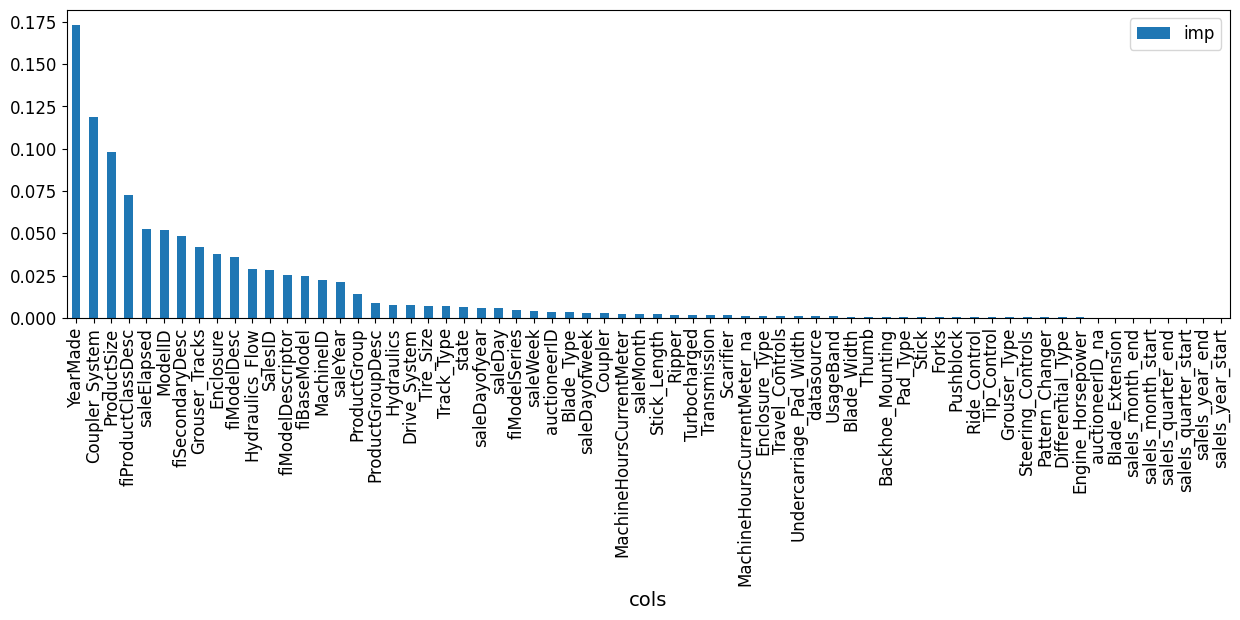

In [37]:
featImp.plot('cols', 'imp', 'bar', figsize=(15, 4))

* Now based on this table, ideally when doing feat importance methods, we want to `discard` columns/features form the `training set` that are not important
* We may not bump up in accuracy along the way, but that's not the purpose
* The purpose is to make the model be trained on `fewer` columns but be as accurate with the ver trained on the entire dataset
* The new model version itself will be `simpler` and it be better at `generalizing` to out-of-training distribution
* We have to manually decide the `importance threshold` though, we begin by first setting it as *0.005*

In [38]:
# create a frame with features that are greater than 0.005
feats_to_keep = featImp[featImp.imp > 0.005].cols

# dimensions (rows, )
len(feats_to_keep)

25

In [14]:
xxxxxxxx

NameError: name 'xxxxxxx' is not defined

# XX One Hot Encode (@ 41:00)

### XX. Lecture Notes

* Earlier we had converted `UsageBands` to 
    * High $\rightarrow$ 0
    * Low $\rightarrow$ 1
    * Medium $\rightarrow$ 2
* Obv. RF doesnt know the categories, it just sees 0,1 and 2
* Now we can get about two or three `nested` splits here
* But lets say, for sake of argument, we had a wider range, with columns such as Very Low, Very Medium, Very High or Unknown
* Have a larger `range` of columns would `increase` the `number of splits`
* This is inefficient as the everytime we do a nested split, we are `halving` the amount of data
* Instead of this we can split the individual columns into `binary format` for e.g. say *isVeryLow*, *isVeryMedium*, or *isVeryHigh*
* And this essentially allows us to reduce the number of `nested splits` which is ideal for efficiency down to 1

---

* This is known as `one-hot encoding` of data points
* ANd it is fine if we have too many columns being too similar since `linear models hate co-linearity` 
* In our case it is not that big of a deal
* We are mainly doing one-hot encoding for the sake of `interpreting` your ML model
* Sometimes it might reveal the true `influence/importance` of a feature that was latent when the nested splits could not capture the `true insight` of its influence
* One-hot encoding is performed by pandas using the `pd.get_dummies` $\rightarrow$ you can get more info on this using `??numericalize`

---

* It is mainly implemented by setting the `max_cats` argument in `proc_df`
* This argument decides if the limiting number of columns has `cardinality` that must be less than max_cats
* For example, UsageBands has Low, Medium and High, i.e. cardinality = 3, Sex has Male, Female i.e. cardinality = 2
* So here if we set max_cats = 7, all of those with cardinality less than 7 will be one-hot encoded

---

* Awkward question asked `@53:02 - @53:35`, actually not so awkward :D ... the question is that some data will be organised very orderly by lets say having a `grading system` 
* A grading system for example saying values shift from poor, to good, to very good
* Then, using dummy variables (one-hot encoding) might destroy this order, how do we overcome it ?

[ANS] You can easily make it an integer to prevent destruction of the order with `proc_df` by equalling it to its `cat.codes`, for example **df_raw.UsageBands = df_raw.UsageBands.cat.codes**

### XXX. Code

# X. Removing Redundant Features (@ 54:50)

## X Lecture Notes

* This builds up from hierarchial sorting of importance
* You can remove these features with the help of `dendograms`
* This is a type of `heirarchical clustering` algorithm
* Cluster analysis allows us to look at rows or columns and decide which ones are similar
* A good example of cluster analysis is `k-means`
* In heirarchical or anglomerative clustering, we look at every `pair` of `objects/points`
* And then decide which two objects are the closest
* Given those, delete them and replace them with an average that sits in the middle of those points
* Then iteratively perform this `pairwise combining` that is taking a pair of points and replacing them with their averages

---

* In our example, we instead of looking at pair of points/objects, we look at the pair of `columns` and/or `variables`
* We want to know which two `tree variables` are the most similar
* The horizonal axis of the dendogram shows how similar are the two variables being compared
* If the vertical line is more to right, the variables are more similar
* In this particular example we use the units of `Spearman's R` to tell the difference between the varaibles
* `Correlation coeff.` are almost similar to `R^2`, except correlation is between two variables, and R^2 is between the variable and its prediction
* ALso we instead of comparing the points directly, we compare their `rank`, this will help fortify our `linearity assumption` when testing the correlation between variables

---

* After that we get the (@ 1:04:33) `out of band score`
* Here it does rf on some dataframe and get the oob_score on that
* The idea is to compare the effect on the oob_score_ after removing some of the variables one at a time
* First you get a baseline oob_score_ by training on the entire data frame
* Then you sequentially remove variables and test the scores, if it improves, then remove that variable

### 3.4.2. Code

## 3.6. Partial Dependence (@ 1:07:20)

### 3.6.1. Lecture Notes

* Technique is not very well-known but is very powerfull
* 

### 3.6.2. Code